In [2]:
import math
import numpy as np
import pandas 
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, average_precision_score,classification_report,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from imblearn.combine import SMOTETomek

In [3]:
# import training data
rd_training = pandas.read_csv('TrainingData.csv', header=0)
rd_training

,sulfate,sulfate_binary,TWI,precip. seasonality,precip. driest quarter,precip. warmest quarter,precip. coldest quarter,annual precipitation,annual mean temperature,coastline distance,N fertilizer use,land subsidence,soil pH,population density,volcano distance,water table depth,land use-urban,sedimentary rock
0,9500.0,1,0.789777,0.675393,0.001053,0.041584,0.000117,0.034713,0.809366,0.872019,0.008616,0.4,0.478261,0.010025,0.134321,0.003664,0,1
1,5715.0,1,0.851489,0.507920,0.016356,0.031161,0.002640,0.029373,0.767517,0.573724,0.025989,0.8,0.782609,0.003026,0.078952,0.021753,0,1
2,4890.0,1,0.700947,0.119834,0.094467,0.026924,0.010528,0.047046,0.695215,0.784656,0.006728,0.4,0.507246,0.003564,0.096995,0.010805,0,1
3,4760.0,1,0.755319,0.053897,0.099831,0.036263,0.011785,0.047408,0.529801,0.701828,0.006371,0.4,0.492754,0.000190,0.278102,0.002052,0,1
4,4451.0,1,0.829787,0.560480,0.015339,0.036374,0.002237,0.034638,0.781769,0.587915,0.020678,1.0,0.618357,0.163435,0.083124,0.006175,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17913,0.0,0,0.787234,0.384751,0.020371,0.073113,0.002270,0.081456,0.795318,0.829239,0.022419,0.6,0.405797,0.006690,0.068721,0.002352,0,1
17914,0.0,0,0.829787,0.451886,0.015802,0.312824,0.001937,0.169774,0.777872,0.714330,0.020193,0.8,0.318841,0.014130,0.082062,0.002537,0,1
17915,0.0,0,0.708160,0.393444,0.015519,0.131263,0.001730,0.124829,0.780981,0.856259,0.010161,0.2,0.275362,0.001196,0.038438,0.002034,0,1
17916,0.0,0,0.741787,0.311280,0.030526,0.113461,0.003402,0.082531,0.762951,0.722538,0.001338,0.4,0.304348,0.000615,0.044061,0.002319,0,1


In [4]:
y = rd_training.sulfate_binary 
x = rd_training.drop(['sulfate','sulfate_binary'], axis=1)  

In [5]:
# data split
x_train, x_1, y_train, y_1= train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train2, x_2, y_train2, y_2 = train_test_split(x_train, y_train,  test_size=0.25, stratify=y_train, random_state=42)
x_train3, x_3, y_train3, y_3 = train_test_split(x_train2, y_train2, test_size=1/3, stratify=y_train2, random_state=42)
x_5, x_4, y_5, y_4= train_test_split(x_train3, y_train3, test_size=0.5, stratify=y_train3, random_state=42)
print(y_1.shape,y_2.shape,y_3.shape,y_4.shape,y_5.shape)

(3584,) (3584,) (3584,) (3583,) (3583,)


In [6]:
def calc_metrics(labels_test, test_probs, threshold = 0.5):
    scores = [1 if x>=threshold else 0 for x in test_probs]
    auc = roc_auc_score(labels_test, test_probs)
    kappa = cohen_kappa_score(labels_test,scores)
    confusion = confusion_matrix(labels_test,scores, labels=list(set(labels_test)))
    print('thresh: %.2f, kappa: %.3f, AUC test-set: %.3f'%(threshold, kappa, auc))
    print(confusion)
    print(classification_report(labels_test,scores))
    return 

In [11]:
# model training and validation 1
x_train_1 = pandas.concat([x_1, x_2, x_3, x_4], axis=0)
y_train_1 = pandas.concat([y_1, y_2, y_3, y_4], axis=0)
def bo_rf(n_estimators, max_features, min_samples_leaf):
        val = cross_val_score(
               RandomForestClassifier(n_estimators=int(n_estimators),max_features=int(max_features),
                           min_samples_leaf=int(min_samples_leaf),
                           random_state=42),x_train_1 , y_train_1 , scoring='roc_auc', cv=5).mean()
        return val
RF_bo = BayesianOptimization(bo_rf, {'n_estimators': (1000, 5000),
        'max_features': (1, 15),
        'min_samples_leaf': (1, 10)})
RF_bo.maximize(init_points=5,   
                   n_iter=10,  
                   )
print(RF_bo.max)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.8984    | 12.6      | 6.854     | 3.331e+03 |
| 2         | 0.8988    | 4.235     | 1.295     | 4.208e+03 |
| 3         | 0.8969    | 14.11     | 8.285     | 2.788e+03 |
| 4         | 0.8983    | 10.71     | 3.074     | 4.383e+03 |
| 5         | 0.8989    | 10.58     | 9.551     | 1.882e+03 |
| 6         | 0.8993    | 3.357     | 1.482     | 3.933e+03 |
| 7         | 0.9012    | 5.183     | 8.382     | 1.274e+03 |
| 8         | 0.9014    | 4.092     | 8.671     | 1.275e+03 |
| 9         | 0.9019    | 3.782     | 7.461     | 1.29e+03  |
| 10        | 0.8952    | 1.458     | 9.012     | 1.317e+03 |
| 11        | 0.8898    | 15.0      | 1.0       | 1.286e+03 |
| 12        | 0.901     | 3.29      | 9.677     | 1.294e+03 |
| 13        | 0.8961    | 1.248     | 8.598     | 1.284e+03 |
| 14        | 0.9009    | 6.659     | 3.633     | 1.293e+03 |
| 15    

Resampled dataset shape Counter({0: 12992, 1: 12992})
Test cohen's kappa: 0.45
Test accuracy: 0.88
Test Sensitivity: 0.69 Test Specificity: 0.9
ROC_AUC 0.9
Sensitivity at the intersection point: 0.82
Specificity at the intersection point: 0.83


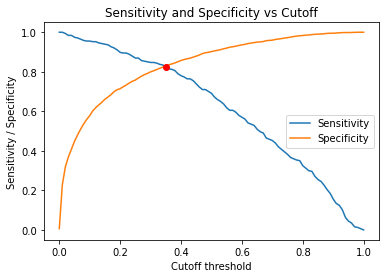

Cutoff value for sensitivity and specificity intersection: 0.35
Cutoff at sensitivity = 0.9: 0.2
Specificity at sensitivity = 0.9: 0.71


In [12]:
# model testing 1

x_train_1 = pandas.concat([x_1, x_2, x_3, x_4], axis=0)
y_train_1 = pandas.concat([y_1, y_2, y_3, y_4], axis=0)
st = SMOTETomek(random_state = 42)
x_bigtrain_re_1, y_bigtrain_re_1 = st.fit_resample(x_train_1, y_train_1)
print('Resampled dataset shape %s' % Counter(y_bigtrain_re_1))
rfc_cv_1 = RandomForestClassifier(n_estimators=1290, max_features=4, oob_score =True, min_samples_leaf = 7,random_state = 0) 
rfc_cv_1.fit(x_bigtrain_re_1, y_bigtrain_re_1)

# performance metrics
y_test_pred_5 = rfc_cv_1.predict(x_5)
y_test_probs_5 = rfc_cv_1.predict_proba(x_5)[:,1]
cm_test = confusion_matrix(y_5, y_test_pred_5, labels=[0, 1])
TN,FP,FN,TP = confusion_matrix(y_5,y_test_pred_5, labels=[0, 1]).ravel()
accuracy_test = round((TP+TN)/(TP+TN+FP+FN),2)
Sensitivity_test, Specificity_test = round(TP/(TP+FN),2),round(TN/(TN+FP),2)
cohen_kappa_score_test = round(cohen_kappa_score(y_5,y_test_pred_5),2)
print("Test cohen's kappa:",cohen_kappa_score_test)
print("Test accuracy:",accuracy_test)
print("Test Sensitivity:",Sensitivity_test, "Test Specificity:",Specificity_test)
predictions_validation = rfc_cv_1.predict_proba(x_5)[:, 1]
fpr, tpr, _ = roc_curve(y_5, predictions_validation)
roc_auc = auc(fpr, tpr)
print('ROC_AUC',round(roc_auc,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_5 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_5, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for the intersection point of sensitivity and specificity
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
diff = sensitivity - specificity
idx = np.argmin(np.abs(diff))
cutoff_intersection = cutoffs[idx]

# Output the sensitivity and specificity at the intersection point
print('Sensitivity at the intersection point:', round(sensitivity[idx],2))
print('Specificity at the intersection point:', round(specificity[idx],2))

# Plot the cutoff threshold and sensitivity and specificity
plt.plot(cutoffs, sensitivities, label='Sensitivity')
plt.plot(cutoffs, specificities, label='Specificity')
plt.xlabel('Cutoff threshold')
plt.ylabel('Sensitivity / Specificity')
plt.title('Sensitivity and Specificity vs Cutoff')
plt.legend()
plt.plot(cutoff_intersection, sensitivity[idx], 'ro', label='Intersection')
plt.show()
print('Cutoff value for sensitivity and specificity intersection:', round(cutoff_intersection,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_5 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_5, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for sensitivity = 0.9
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
target_sensitivity = 0.9
idx_2 = np.where(sensitivity <= target_sensitivity)[0][0]

# Calculate cutoff and specificity at sensitivity = 0.9
cutoff_at_sensitivity_09 = cutoffs[idx_2]
specificity_at_sensitivity_09 = specificity[idx_2]
print('Cutoff at sensitivity = 0.9:', cutoff_at_sensitivity_09)
print('Specificity at sensitivity = 0.9:', round(specificity_at_sensitivity_09,2))

In [13]:
# model training and validation 2
x_train_2 = pandas.concat([x_1, x_2, x_3, x_5], axis=0)
y_train_2 = pandas.concat([y_1, y_2, y_3, y_5], axis=0)
def bo_rf(n_estimators, max_features, min_samples_leaf):
        val = cross_val_score(
               RandomForestClassifier(n_estimators=int(n_estimators),max_features=int(max_features),
                           min_samples_leaf=int(min_samples_leaf),
                           random_state=42), x_train_2 , y_train_2 , scoring='roc_auc', cv=5).mean()
        return val
RF_bo = BayesianOptimization(bo_rf, {'n_estimators': (1000, 5000),
        'max_features': (1, 15),
        'min_samples_leaf': (1, 10)})
RF_bo.maximize(init_points=5,   
                   n_iter=10,  
                   )
print(RF_bo.max)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.898     | 6.355     | 3.165     | 1.345e+03 |
| 2         | 0.8955    | 12.46     | 5.529     | 2.094e+03 |
| 3         | 0.8981    | 1.538     | 1.678     | 3.638e+03 |
| 4         | 0.8929    | 10.21     | 1.66      | 2.684e+03 |
| 5         | 0.8951    | 13.14     | 7.565     | 3.174e+03 |
| 6         | 0.8987    | 6.248     | 4.092     | 1.344e+03 |
| 7         | 0.8987    | 6.387     | 6.871     | 1.34e+03  |
| 8         | 0.898     | 6.846     | 9.627     | 1.345e+03 |
| 9         | 0.8934    | 1.96      | 8.133     | 1.343e+03 |
| 10        | 0.8967    | 9.042     | 6.257     | 1.343e+03 |
| 11        | 0.8991    | 5.148     | 4.378     | 1.341e+03 |
| 12        | 0.8971    | 7.406     | 3.322     | 1.338e+03 |
| 13        | 0.8997    | 3.439     | 3.09      | 1.343e+03 |
| 14        | 0.8981    | 1.253     | 1.486     | 1.345e+03 |
| 15    

Resampled dataset shape Counter({0: 13000, 1: 13000})
Test cohen's kappa: 0.47
Test accuracy: 0.89
Test Sensitivity: 0.67 Test Specificity: 0.92
ROC_AUC 0.91
Sensitivity at the intersection point: 0.83
Specificity at the intersection point: 0.84


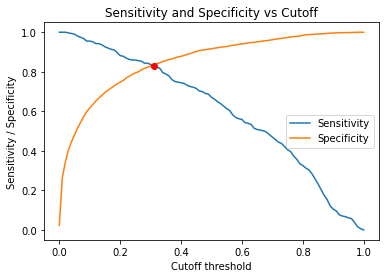

Cutoff value for sensitivity and specificity intersection: 0.31
Cutoff at sensitivity = 0.9: 0.19
Specificity at sensitivity = 0.9: 0.74


In [14]:
# model testing 2

x_train_2 = pandas.concat([x_1, x_2, x_3, x_5], axis=0)
y_train_2 = pandas.concat([y_1, y_2, y_3, y_5], axis=0)
st = SMOTETomek(random_state = 42)
x_bigtrain_re_2, y_bigtrain_re_2 = st.fit_resample(x_train_2, y_train_2)
print('Resampled dataset shape %s' % Counter(y_bigtrain_re_2))
rfc_cv_2 = RandomForestClassifier(n_estimators=1343, max_features=3, oob_score =True, min_samples_leaf = 3,random_state = 0) 
rfc_cv_2.fit(x_bigtrain_re_2, y_bigtrain_re_2)

# performance metrics
y_test_pred_4 = rfc_cv_2.predict(x_4)
y_test_probs_4 = rfc_cv_2.predict_proba(x_4)[:,1]
cm_test = confusion_matrix(y_4, y_test_pred_4, labels=[0, 1])
TN,FP,FN,TP = confusion_matrix(y_4,y_test_pred_4, labels=[0, 1]).ravel()
accuracy_test = round((TP+TN)/(TP+TN+FP+FN),2)
Sensitivity_test, Specificity_test = round(TP/(TP+FN),2),round(TN/(TN+FP),2)
cohen_kappa_score_test = round(cohen_kappa_score(y_4,y_test_pred_4),2)
print("Test cohen's kappa:",cohen_kappa_score_test)
print("Test accuracy:",accuracy_test)
print("Test Sensitivity:",Sensitivity_test, "Test Specificity:",Specificity_test)
predictions_validation = rfc_cv_2.predict_proba(x_4)[:, 1]
fpr, tpr, _ = roc_curve(y_4, predictions_validation)
roc_auc = auc(fpr, tpr)
print('ROC_AUC',round(roc_auc,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_4 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_4, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for the intersection point of sensitivity and specificity
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
diff = sensitivity - specificity
idx = np.argmin(np.abs(diff))
cutoff_intersection = cutoffs[idx]

# Output the sensitivity and specificity at the intersection point
print('Sensitivity at the intersection point:', round(sensitivity[idx],2))
print('Specificity at the intersection point:', round(specificity[idx],2))

# Plot the cutoff threshold and sensitivity and specificity
plt.plot(cutoffs, sensitivities, label='Sensitivity')
plt.plot(cutoffs, specificities, label='Specificity')
plt.xlabel('Cutoff threshold')
plt.ylabel('Sensitivity / Specificity')
plt.title('Sensitivity and Specificity vs Cutoff')
plt.legend()
plt.plot(cutoff_intersection, sensitivity[idx], 'ro', label='Intersection')
plt.show()
print('Cutoff value for sensitivity and specificity intersection:', round(cutoff_intersection,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_4 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_4, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for sensitivity = 0.9
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
target_sensitivity = 0.9
idx_2 = np.where(sensitivity <= target_sensitivity)[0][0]

# Calculate cutoff and specificity at sensitivity = 0.9
cutoff_at_sensitivity_09 = cutoffs[idx_2]
specificity_at_sensitivity_09 = specificity[idx_2]
print('Cutoff at sensitivity = 0.9:', cutoff_at_sensitivity_09)
print('Specificity at sensitivity = 0.9:', round(specificity_at_sensitivity_09,2))

In [15]:
# model training and validation 3
x_train_3 = pandas.concat([x_1, x_2, x_4, x_5], axis=0)
y_train_3 = pandas.concat([y_1, y_2, y_4, y_5], axis=0)
def bo_rf(n_estimators, max_features, min_samples_leaf):
        val = cross_val_score(
               RandomForestClassifier(n_estimators=int(n_estimators),max_features=int(max_features),
                           min_samples_leaf=int(min_samples_leaf),
                           random_state=42), x_train_3 , y_train_3 , scoring='roc_auc', cv=5).mean()
        return val
RF_bo = BayesianOptimization(bo_rf, {'n_estimators': (1000, 5000),
        'max_features': (1, 15),
        'min_samples_leaf': (1, 10)})
RF_bo.maximize(init_points=5,   
                   n_iter=10,  
                   )
print(RF_bo.max)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.8971    | 5.296     | 1.25      | 1.161e+03 |
| 2         | 0.9013    | 3.211     | 4.95      | 2.179e+03 |
| 3         | 0.8908    | 14.46     | 1.625     | 2.792e+03 |
| 4         | 0.8971    | 10.34     | 4.117     | 2.978e+03 |
| 5         | 0.8998    | 6.005     | 6.578     | 3.281e+03 |
| 6         | 0.8947    | 9.56      | 1.337     | 2.257e+03 |
| 7         | 0.9008    | 4.948     | 5.221     | 2.179e+03 |
| 8         | 0.8944    | 1.891     | 9.196     | 2.195e+03 |
| 9         | 0.9       | 1.0       | 1.0       | 2.171e+03 |
| 10        | 0.8954    | 1.756     | 8.966     | 3.266e+03 |
| 11        | 0.8976    | 7.126     | 2.283     | 3.294e+03 |
| 12        | 0.8944    | 1.98      | 9.467     | 2.175e+03 |
| 13        | 0.9005    | 5.016     | 6.217     | 2.183e+03 |
| 14        | 0.8958    | 7.842     | 1.354     | 2.181e+03 |
| 15    

Resampled dataset shape Counter({0: 12980, 1: 12980})
Test cohen's kappa: 0.45
Test accuracy: 0.89
Test Sensitivity: 0.66 Test Specificity: 0.91
ROC_AUC 0.9
Sensitivity at the intersection point: 0.83
Specificity at the intersection point: 0.84


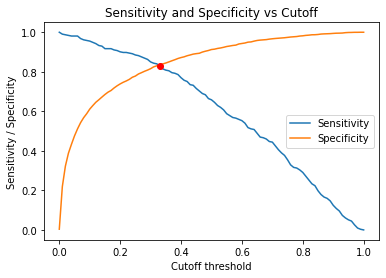

Cutoff value for sensitivity and specificity intersection: 0.33
Cutoff at sensitivity = 0.9: 0.21
Specificity at sensitivity = 0.9: 0.75


In [15]:
# model testing 3

x_train_3 = pandas.concat([x_1, x_2, x_4, x_5], axis=0)
y_train_3 = pandas.concat([y_1, y_2, y_4, y_5], axis=0)
st = SMOTETomek(random_state = 42)
x_bigtrain_re_3, y_bigtrain_re_3 = st.fit_resample(x_train_3, y_train_3)
print('Resampled dataset shape %s' % Counter(y_bigtrain_re_3))
rfc_cv_3 = RandomForestClassifier(n_estimators=2179, max_features=3, oob_score =True, min_samples_leaf = 5,random_state = 0) 
rfc_cv_3.fit(x_bigtrain_re_3, y_bigtrain_re_3)

# performance metrics
y_test_pred_3 = rfc_cv_3.predict(x_3)
y_test_probs_3 = rfc_cv_3.predict_proba(x_3)[:,1]
cm_test = confusion_matrix(y_3, y_test_pred_3, labels=[0, 1])
TN,FP,FN,TP = confusion_matrix(y_3, y_test_pred_3, labels=[0, 1]).ravel()
accuracy_test = round((TP+TN)/(TP+TN+FP+FN),2)
Sensitivity_test, Specificity_test = round(TP/(TP+FN),2),round(TN/(TN+FP),2)
cohen_kappa_score_test = round(cohen_kappa_score(y_3, y_test_pred_3),2)
print("Test cohen's kappa:",cohen_kappa_score_test)
print("Test accuracy:",accuracy_test)
print("Test Sensitivity:",Sensitivity_test, "Test Specificity:",Specificity_test)
predictions_validation = rfc_cv_3.predict_proba(x_3)[:, 1]
fpr, tpr, _ = roc_curve(y_3, predictions_validation)
roc_auc = auc(fpr, tpr)
print('ROC_AUC',round(roc_auc,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_3 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_3, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for the intersection point of sensitivity and specificity
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
diff = sensitivity - specificity
idx = np.argmin(np.abs(diff))
cutoff_intersection = cutoffs[idx]

# Output the sensitivity and specificity at the intersection point
print('Sensitivity at the intersection point:', round(sensitivity[idx],2))
print('Specificity at the intersection point:', round(specificity[idx],2))

# Plot the cutoff threshold and sensitivity and specificity
plt.plot(cutoffs, sensitivities, label='Sensitivity')
plt.plot(cutoffs, specificities, label='Specificity')
plt.xlabel('Cutoff threshold')
plt.ylabel('Sensitivity / Specificity')
plt.title('Sensitivity and Specificity vs Cutoff')
plt.legend()
plt.plot(cutoff_intersection, sensitivity[idx], 'ro', label='Intersection')
plt.show()
print('Cutoff value for sensitivity and specificity intersection:', round(cutoff_intersection,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_3 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_3, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for sensitivity = 0.9
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
target_sensitivity = 0.9
idx_2 = np.where(sensitivity <= target_sensitivity)[0][0]

# Calculate cutoff and specificity at sensitivity = 0.9
cutoff_at_sensitivity_09 = cutoffs[idx_2]
specificity_at_sensitivity_09 = specificity[idx_2]
print('Cutoff at sensitivity = 0.9:', cutoff_at_sensitivity_09)
print('Specificity at sensitivity = 0.9:', round(specificity_at_sensitivity_09,2))

In [17]:
# model training and validation 4
x_train_4 = pandas.concat([x_1, x_3, x_4, x_5], axis=0)
y_train_4 = pandas.concat([y_1, y_3, y_4, y_5], axis=0)
def bo_rf(n_estimators, max_features, min_samples_leaf):
        val = cross_val_score(
               RandomForestClassifier(n_estimators=int(n_estimators),max_features=int(max_features),
                           min_samples_leaf=int(min_samples_leaf),
                           random_state=42), x_train_4 , y_train_4 , scoring='roc_auc', cv=5).mean()
        return val
RF_bo = BayesianOptimization(bo_rf, {'n_estimators': (1000, 5000),
        'max_features': (1, 15),
        'min_samples_leaf': (1, 10)})
RF_bo.maximize(init_points=5,   
                   n_iter=10,  
                   )
print(RF_bo.max)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.8932    | 12.37     | 5.863     | 1.518e+03 |
| 2         | 0.8928    | 1.389     | 7.394     | 1.629e+03 |
| 3         | 0.8938    | 11.62     | 4.164     | 3.634e+03 |
| 4         | 0.896     | 7.811     | 4.311     | 2.153e+03 |
| 5         | 0.8986    | 3.811     | 5.578     | 3.75e+03  |
| 6         | 0.8957    | 8.303     | 5.61      | 2.151e+03 |
| 7         | 0.8971    | 4.89      | 8.094     | 3.77e+03  |
| 8         | 0.8931    | 13.73     | 7.351     | 3.725e+03 |
| 9         | 0.8921    | 14.55     | 9.929     | 3.755e+03 |
| 10        | 0.8949    | 1.101     | 5.065     | 3.753e+03 |
| 11        | 0.8968    | 6.851     | 5.499     | 3.749e+03 |
| 12        | 0.8978    | 4.424     | 7.614     | 3.751e+03 |
| 13        | 0.8973    | 3.455     | 8.343     | 3.746e+03 |
| 14        | 0.8965    | 4.352     | 1.29      | 3.747e+03 |
| 15    

Resampled dataset shape Counter({0: 12977, 1: 12977})
Test cohen's kappa: 0.5
Test accuracy: 0.9
Test Sensitivity: 0.73 Test Specificity: 0.91
ROC_AUC 0.92
Sensitivity at the intersection point: 0.84
Specificity at the intersection point: 0.84


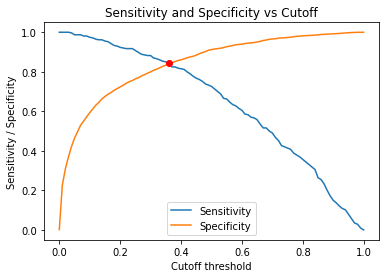

Cutoff value for sensitivity and specificity intersection: 0.36
Cutoff at sensitivity = 0.9: 0.26
Specificity at sensitivity = 0.9: 0.77


In [16]:
# model testing 4

x_train_4 = pandas.concat([x_1, x_3, x_4, x_5], axis=0)
y_train_4 = pandas.concat([y_1, y_3, y_4, y_5], axis=0)
st = SMOTETomek(random_state = 42)
x_bigtrain_re_4, y_bigtrain_re_4 = st.fit_resample(x_train_4, y_train_4)
print('Resampled dataset shape %s' % Counter(y_bigtrain_re_4))
rfc_cv_4 = RandomForestClassifier(n_estimators=3750, max_features=4, oob_score =True, min_samples_leaf = 6,random_state = 0) 
rfc_cv_4.fit(x_bigtrain_re_4, y_bigtrain_re_4)

# performance metrics
y_test_pred_2 = rfc_cv_4.predict(x_2)
y_test_probs_2 = rfc_cv_4.predict_proba(x_2)[:,1]
cm_test = confusion_matrix(y_2, y_test_pred_2, labels=[0, 1])
TN,FP,FN,TP = confusion_matrix(y_2,y_test_pred_2, labels=[0, 1]).ravel()
accuracy_test = round((TP+TN)/(TP+TN+FP+FN),2)
Sensitivity_test, Specificity_test = round(TP/(TP+FN),2),round(TN/(TN+FP),2)
cohen_kappa_score_test = round(cohen_kappa_score(y_2,y_test_pred_2),2)
print("Test cohen's kappa:",cohen_kappa_score_test)
print("Test accuracy:",accuracy_test)
print("Test Sensitivity:",Sensitivity_test, "Test Specificity:",Specificity_test)
predictions_validation = rfc_cv_4.predict_proba(x_2)[:, 1]
fpr, tpr, _ = roc_curve(y_2, predictions_validation)
roc_auc = auc(fpr, tpr)
print('ROC_AUC',round(roc_auc,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_2 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_2, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for the intersection point of sensitivity and specificity
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
diff = sensitivity - specificity
idx = np.argmin(np.abs(diff))
cutoff_intersection = cutoffs[idx]

# Output the sensitivity and specificity at the intersection point
print('Sensitivity at the intersection point:', round(sensitivity[idx],2))
print('Specificity at the intersection point:', round(specificity[idx],2))

# Plot the cutoff threshold and sensitivity and specificity
plt.plot(cutoffs, sensitivities, label='Sensitivity')
plt.plot(cutoffs, specificities, label='Specificity')
plt.xlabel('Cutoff threshold')
plt.ylabel('Sensitivity / Specificity')
plt.title('Sensitivity and Specificity vs Cutoff')
plt.legend()
plt.plot(cutoff_intersection, sensitivity[idx], 'ro', label='Intersection')
plt.show()
print('Cutoff value for sensitivity and specificity intersection:', round(cutoff_intersection,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_2 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_2, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for sensitivity = 0.9
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
target_sensitivity = 0.9
idx_2 = np.where(sensitivity <= target_sensitivity)[0][0]

# Calculate cutoff and specificity at sensitivity = 0.9
cutoff_at_sensitivity_09 = cutoffs[idx_2]
specificity_at_sensitivity_09 = specificity[idx_2]
print('Cutoff at sensitivity = 0.9:', cutoff_at_sensitivity_09)
print('Specificity at sensitivity = 0.9:', round(specificity_at_sensitivity_09,2))

In [18]:
# model training and validation 5
x_train_5 = pandas.concat([x_2, x_3, x_4, x_5], axis=0)
y_train_5 = pandas.concat([y_2, y_3, y_4, y_5], axis=0)
def bo_rf(n_estimators, max_features, min_samples_leaf):
        val = cross_val_score(
               RandomForestClassifier(n_estimators=int(n_estimators),max_features=int(max_features),
                           min_samples_leaf=int(min_samples_leaf),
                           random_state=42), x_train_5 , y_train_5 , scoring='roc_auc', cv=5).mean()
        return val
RF_bo = BayesianOptimization(bo_rf, {'n_estimators': (1000, 5000),
        'max_features': (1, 15),
        'min_samples_leaf': (1, 10)})
RF_bo.maximize(init_points=5,   
                   n_iter=10,  
                   )
print(RF_bo.max)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.902     | 12.48     | 4.603     | 3.422e+03 |
| 2         | 0.9045    | 5.381     | 8.058     | 3.899e+03 |
| 3         | 0.9052    | 3.634     | 6.911     | 1.189e+03 |
| 4         | 0.9006    | 12.39     | 2.679     | 4.394e+03 |
| 5         | 0.9018    | 12.5      | 9.821     | 4.678e+03 |
| 6         | 0.9049    | 4.499     | 7.134     | 1.191e+03 |
| 7         | 0.906     | 3.338     | 5.567     | 1.167e+03 |
| 8         | 0.9015    | 1.844     | 5.306     | 1.123e+03 |
| 9         | 0.9056    | 5.826     | 6.893     | 3.942e+03 |
| 10        | 0.9042    | 5.8       | 9.612     | 3.978e+03 |
| 11        | 0.8994    | 14.76     | 2.038     | 3.844e+03 |
| 12        | 0.8994    | 11.66     | 1.679     | 4.056e+03 |
| 13        | 0.9044    | 5.356     | 1.053     | 2.278e+03 |
| 14        | 0.9017    | 13.4      | 8.914     | 2.329e+03 |
| 15    

Resampled dataset shape Counter({0: 12983, 1: 12983})
Test cohen's kappa: 0.44
Test accuracy: 0.88
Test Sensitivity: 0.65 Test Specificity: 0.91
ROC_AUC 0.89
Sensitivity at the intersection point: 0.81
Specificity at the intersection point: 0.81


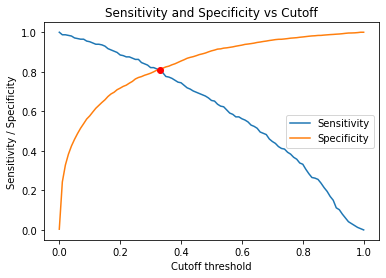

Cutoff value for sensitivity and specificity intersection: 0.33
Cutoff at sensitivity = 0.9: 0.19
Specificity at sensitivity = 0.9: 0.71


In [17]:
# model testing 5

x_train_5 = pandas.concat([x_2, x_3, x_4, x_5], axis=0)
y_train_5 = pandas.concat([y_2, y_3, y_4, y_5], axis=0)
st = SMOTETomek(random_state = 42)
x_bigtrain_re_5, y_bigtrain_re_5 = st.fit_resample(x_train_5, y_train_5)
print('Resampled dataset shape %s' % Counter(y_bigtrain_re_5))
rfc_cv_5 = RandomForestClassifier(n_estimators=1167, max_features=3, oob_score =True, min_samples_leaf = 6,random_state = 0) 
rfc_cv_5.fit(x_bigtrain_re_5, y_bigtrain_re_5)

# performance metrics
y_test_pred_1 = rfc_cv_5.predict(x_1)
y_test_probs_1 = rfc_cv_5.predict_proba(x_1)[:,1]
cm_test = confusion_matrix(y_1, y_test_pred_1, labels=[0, 1])
TN,FP,FN,TP = confusion_matrix(y_1,y_test_pred_1, labels=[0, 1]).ravel()
accuracy_test = round((TP+TN)/(TP+TN+FP+FN),2)
Sensitivity_test, Specificity_test = round(TP/(TP+FN),2),round(TN/(TN+FP),2)
cohen_kappa_score_test = round(cohen_kappa_score(y_1,y_test_pred_1),2)
print("Test cohen's kappa:",cohen_kappa_score_test)
print("Test accuracy:",accuracy_test)
print("Test Sensitivity:",Sensitivity_test, "Test Specificity:",Specificity_test)
predictions_validation = rfc_cv_5.predict_proba(x_1)[:, 1]
fpr, tpr, _ = roc_curve(y_1, predictions_validation)
roc_auc = auc(fpr, tpr)
print('ROC_AUC',round(roc_auc,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_1 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_1, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for the intersection point of sensitivity and specificity
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
diff = sensitivity - specificity
idx = np.argmin(np.abs(diff))
cutoff_intersection = cutoffs[idx]

# Output the sensitivity and specificity at the intersection point
print('Sensitivity at the intersection point:', round(sensitivity[idx],2))
print('Specificity at the intersection point:', round(specificity[idx],2))

# Plot the cutoff threshold and sensitivity and specificity
plt.plot(cutoffs, sensitivities, label='Sensitivity')
plt.plot(cutoffs, specificities, label='Specificity')
plt.xlabel('Cutoff threshold')
plt.ylabel('Sensitivity / Specificity')
plt.title('Sensitivity and Specificity vs Cutoff')
plt.legend()
plt.plot(cutoff_intersection, sensitivity[idx], 'ro', label='Intersection')
plt.show()
print('Cutoff value for sensitivity and specificity intersection:', round(cutoff_intersection,2))

# Compute sensitivity and specificity at different cutoff thresholds
cutoffs = np.linspace(0, 1, 101)
sensitivities = []
specificities = []
for cutoff in cutoffs:
    y_pred_cutoff = (y_test_probs_1 > cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_1, y_pred_cutoff).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Find the cutoff value for sensitivity = 0.9
sensitivity = np.array(sensitivities)
specificity = np.array(specificities)
target_sensitivity = 0.9
idx_2 = np.where(sensitivity <= target_sensitivity)[0][0]

# Calculate cutoff and specificity at sensitivity = 0.9
cutoff_at_sensitivity_09 = cutoffs[idx_2]
specificity_at_sensitivity_09 = specificity[idx_2]
print('Cutoff at sensitivity = 0.9:', cutoff_at_sensitivity_09)
print('Specificity at sensitivity = 0.9:', round(specificity_at_sensitivity_09,2))

In [20]:
# final random forest model training using entire dataset

st = SMOTETomek(random_state = 42)
x_re, y_re = st.fit_resample(x, y)
rfc_final = RandomForestClassifier(n_estimators=1946, max_features=3, min_samples_leaf = 5,random_state = 0) 
rfc_final.fit(x_re, y_re)

RandomForestClassifier(max_features=3, min_samples_leaf=5, n_estimators=1946,
                       random_state=0)